# Quantum Inspire performance test

We compare performance of the simulator with the circuit from

"Overview and Comparison of Gate Level Quantum Software Platforms", https://arxiv.org/abs/1807.02500

## Define the circuit

In [1]:
import time
import os
import numpy as np
from IPython.display import display

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram, circuit_drawer

from quantuminspire.credentials import get_authentication
from quantuminspire.qiskit import QI

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

We define the circuit based on the number of qubits and the depth (e.g. the number of iterations of the unit building block).

D:\dev\quantuminspire-qiskit10\env\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


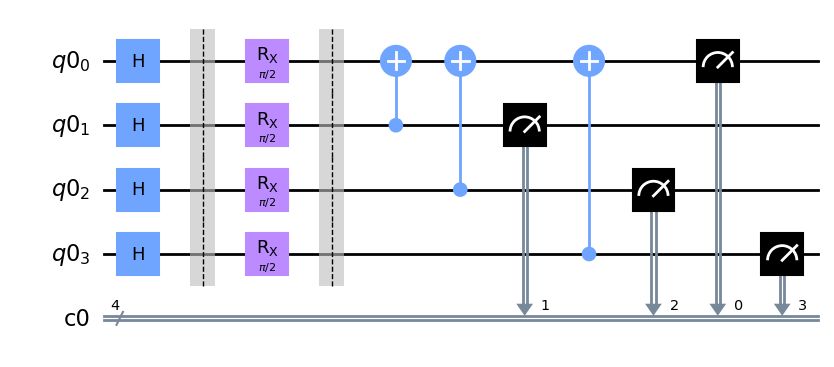

In [2]:
def pcircuit(nqubits, depth = 10):
    """ Circuit to test performance of quantum computer """
    q = QuantumRegister(nqubits)
    ans = ClassicalRegister(nqubits)
    qc = QuantumCircuit(q, ans)

    for level in range(depth):
        for qidx in range(nqubits):
            qc.h( q[qidx] )
        qc.barrier()
        for qidx in range(nqubits):
            qc.rx(np.pi/2, q[qidx])
        qc.barrier()

        for qidx in range(nqubits):
            if qidx!=0:
                qc.cx(q[qidx], q[0])
    for qidx in range(nqubits):
        qc.measure(q[qidx], ans[qidx])
    return q, qc

q,qc = pcircuit(4, 1)
qc.draw(output='mpl')

## Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [3]:
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)

We create a Qiskit backend for the Quantum Inspire interface and execute the circuit generated above.

In [4]:
qi_backend = QI.get_backend('QX single-node simulator')
qc = transpile(qc, qi_backend)
job = qi_backend.run(qc)

We can wait for the results and then print them

In [5]:
result = job.result()
print('Generated histogram:')
print(result.get_counts())

Generated histogram:
{'0000': 61, '0001': 63, '0010': 65, '0011': 71, '0100': 62, '0101': 60, '0110': 62, '0111': 68, '1000': 64, '1001': 64, '1010': 63, '1011': 67, '1100': 63, '1101': 61, '1110': 67, '1111': 63}


Visualization can be done with the normal Python plotting routines, or with the Qiskit SDK.

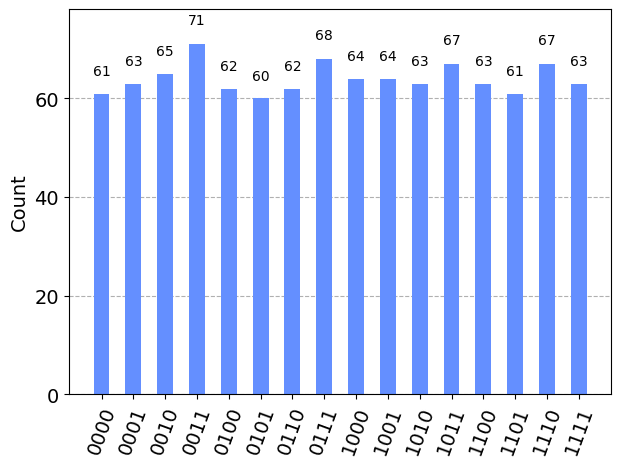

In [6]:
plot_histogram(result.get_counts(qc))

To compare we will run the circuit with 20 qubits and depth 20. This takes:

* Qiskit: 3.7 seconds
* ProjectQ: 2.0 seconds

Our simulator runs for multiple shots (unless full state projection is used). More details will follow later.

In [7]:
q, qc = pcircuit(10, 10)
start_time = time.time()

qc = transpile(qc, qi_backend)
job = qi_backend.run(qc, shots=8)
job.result()
interval = time.time() - start_time

print('time needed: %.1f [s]' % (interval,))

time needed: 3.8 [s]
